## Importations et Configuration du Style

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Configuration du style pour le rendu "publication"
# On utilise une police avec empattement (serif) comme dans les journaux académiques
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

font.family = 'serif' : Les revues scientifiques (comme Addiction où l'article est publié) utilisent généralement des polices avec empattement (Times New Roman, etc.). Ce réglage aligne le style du graphique avec le texte de l'article.

xtick.direction = 'in' : Par convention académique classique, les petites barres des axes (ticks) pointent souvent vers l'intérieur du graphique plutôt que vers l'extérieur.

## Chargement et Nettoyage

In [2]:
# 1. Chargement
# low_memory=False évite des avertissements si les fichiers sont gros ou ont des types mixtes
df_dm1 = pd.read_csv('dm1.csv', low_memory=False)
df_dm2 = pd.read_csv('dm2.csv', low_memory=False)
df_ds1 = pd.read_csv('ds1.csv', low_memory=False)
df_ds2 = pd.read_csv('ds2.csv', low_memory=False)
df_dm = pd.concat([df_dm1, df_dm2])
df_ds = pd.concat([df_ds1,df_ds2])

# La colonne DSSTDY contient des "UNKNOWN" ou des espaces qui la rendent "texte".
# 'coerce' force ces erreurs à devenir NaN (Not a Number), rendant la colonne numérique.
df_ds['DSSTDY'] = pd.to_numeric(df_ds['DSSTDY'], errors='coerce')

# 2. Préparation Population (DM)
# On exclut les 'SCRFAIL' (Screen Failures) : ce sont des patients non randomisés.
df_population = df_dm[df_dm['ARMCD'] != 'SCRFAIL'].copy()

# Identification du contexte (Hospitalisé vs Ambulatoire) basé sur l'ID de l'étude
def categorize_study(study_id):
    if '0001' in str(study_id): return 'In-patient'
    elif '0002' in str(study_id): return 'Out-patient'
    else: return 'Unknown'

df_population['Setting'] = df_population['STUDYID'].apply(categorize_study)
df_population = df_population[['USUBJID', 'ARM', 'Setting']]

# 3. Fusion et Gestion des manquants
# Left Join : On garde TOUS les patients de la population (même ceux sans données de sortie)
# C'est le principe de l'analyse en "Intention de Traiter" (ITT).
df_analysis = pd.merge(df_population, df_ds[['USUBJID', 'DSSTDY']], on='USUBJID', how='left')

# Si la date de sortie est vide (NaN), on remplace par 1 (abandon immédiat)
df_analysis['DSSTDY'] = df_analysis['DSSTDY'].fillna(1)

# On regroupe par patient pour trouver leur DERNIER jour enregistré
df_retention_days = df_analysis.groupby('USUBJID').agg({
    'DSSTDY': 'max',
    'ARM': 'first',
    'Setting': 'first'
}).reset_index()

# Plafonnement à 14 jours (durée de l'étude).
# Si un événement arrive au jour 15 ou 20, il compte comme "complet" (14).
df_retention_days['LastDay'] = df_retention_days['DSSTDY'].clip(upper=14)

fillna(1) : Dans une analyse de survie/rétention conservatrice, si on ignore quand un patient est parti, on suppose le pire scénario (parti dès le début) pour ne pas surestimer le succès du traitement.

groupby(...).agg({'DSSTDY': 'max'}) : Un patient peut avoir plusieurs lignes dans le fichier DS (ex: "Randomisé", "Début traitement", "Fin étude"). Nous voulons savoir jusqu'à quand il est resté, donc nous cherchons le jour maximum.

## Le Calcul de la Courbe de Rétention

In [3]:
def calculate_retention_curve(df, group_col='ARM', setting_col='Setting'):
    results = []
    
    # On travaille sous-groupe par sous-groupe (ex: Clonidine / Ambulatoire)
    groups = df.groupby([group_col, setting_col])
    
    for (arm, setting), data in groups:
        total_n = len(data) # Dénominateur fixe (Nombre de patients au départ)
        
        # Pour chaque jour de 1 à 14
        for day in range(1, 15):
            # On compte ceux dont le dernier jour est >= au jour actuel
            n_retained = data[data['LastDay'] >= day].shape[0]
            proportion = n_retained / total_n
            
            results.append({
                'ARM': arm,
                'Setting': setting,
                'Day': day,
                'Proportion': proportion
            })
            
    return pd.DataFrame(results)
df_plot_data = calculate_retention_curve(df_retention_days)

Approche itérative (Boucle for) : Contrairement à une simple moyenne, la rétention est un calcul cumulatif. À chaque jour t, on vérifie "qui est encore vivant dans l'étude".

Dénominateur fixe (total_n) : Pour calculer une proportion de rétention correcte, on divise toujours par le nombre de patients initialement randomisés, et non par le nombre de patients de la veille. Cela garantit que la courbe démarre à 1.0 (100%) et ne peut que descendre.

## La Visualisation

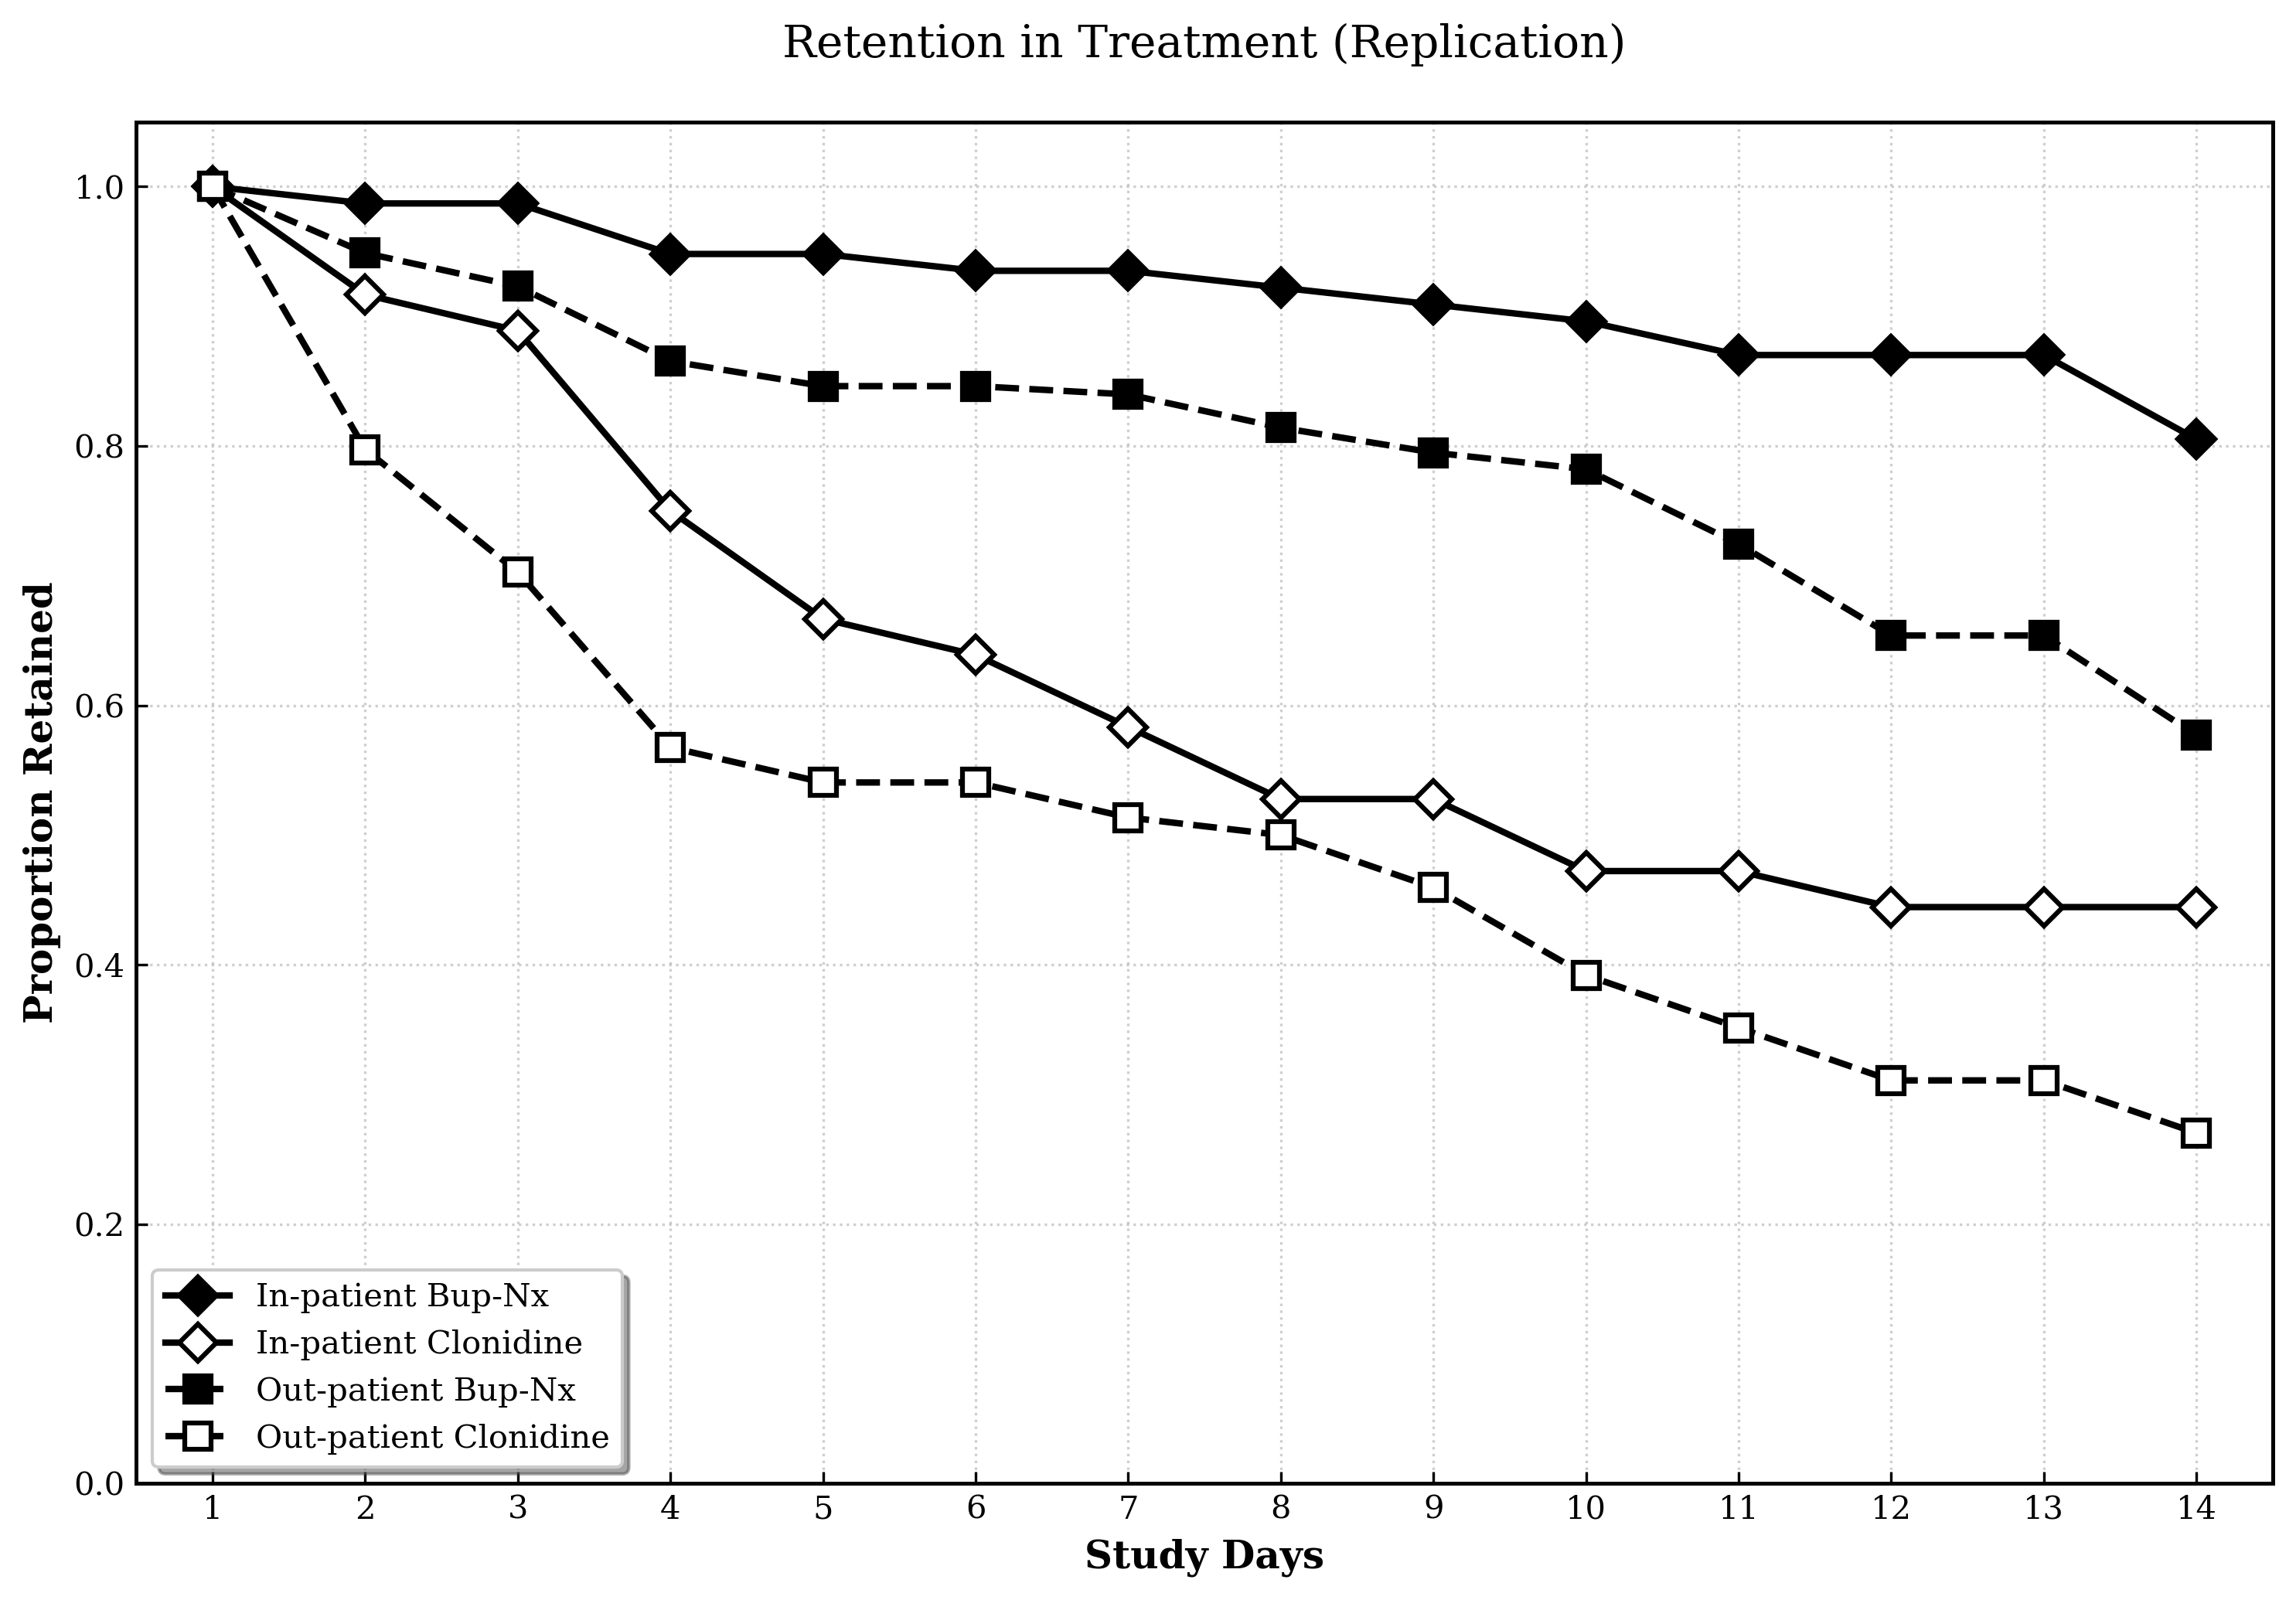

In [4]:
# Configuration de la taille et résolution
plt.figure(figsize=(10, 7), dpi=300)

# Dictionnaire de styles : La clé est (Traitement, Lieu)
styles = {
    ('Bup-Nx', 'In-patient'):   {'fmt': '-D', 'color': 'black', 'mfc': 'black', 'label': 'In-patient Bup-Nx'},
    ('Clonidine', 'In-patient'): {'fmt': '-D', 'color': 'black', 'mfc': 'white', 'label': 'In-patient Clonidine'},
    ('Bup-Nx', 'Out-patient'):  {'fmt': '--s', 'color': 'black', 'mfc': 'black', 'label': 'Out-patient Bup-Nx'},
    ('Clonidine', 'Out-patient'):{'fmt': '--s', 'color': 'black', 'mfc': 'white', 'label': 'Out-patient Clonidine'}
}

# Boucle pour tracer chaque courbe une par une avec son style spécifique
for (arm, setting), style_params in styles.items():
    # Filtre intelligent : cherche "Bup" dans le nom complet du traitement (ex: "BUPRENORPHINE/NALOXONE")
    subset = df_plot_data[
        (df_plot_data['ARM'].str.contains(arm if arm != 'Bup-Nx' else 'Bup', case=False)) & 
        (df_plot_data['Setting'] == setting)
    ].sort_values('Day')
    
    if not subset.empty:
        plt.plot(
            subset['Day'], 
            subset['Proportion'], 
            style_params['fmt'],                  # Ligne continue (-) ou tiretée (--) + Forme (D ou s)
            color=style_params['color'],          # Noir
            markerfacecolor=style_params['mfc'],  # Remplissage : Noir ou Blanc (vide)
            markeredgewidth=1.5,
            linewidth=2,
            markersize=8,
            label=style_params['label']
        )

# Finitions académiques
plt.ylim(0, 1.05)
plt.xlim(0.5, 14.5)
plt.xlabel('Study Days', fontweight='bold', fontsize=12)
plt.ylabel('Proportion Retained', fontweight='bold', fontsize=12)
plt.title('Retention in Treatment (Replication)', pad=20, fontsize=14)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='lower left', frameon=True, shadow=True, fontsize=10)
plt.xticks(range(1, 15))

plt.tight_layout()
plt.show()